In [15]:
from datetime import datetime
import pandas as pd
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import matplotlib.pyplot as plt
import seaborn as sns

# Choose your destiny: 'mainnet' or 'testnet'
network = 'mainnet'  # or 'testnet'
endpoints = {
    'mainnet': 'https://api.poktscan.com/poktscan/api/graphql',
    'testnet': 'https://api.testnet.poktscan.com/poktscan/api/graphql'
}

api_key = str(open("../../POKT Scan.txt", "r").read())

# Set up the headers with the provided API key and content type
headers = {
    "Authorization": api_key,
    "Content-Type": "application/json"
}

# Set up the transport with the chosen GraphQL endpoint and your headers
transport = RequestsHTTPTransport(
    url=endpoints[network],
    headers=headers,
    use_json=True
)

# Create the client
client = Client(transport=transport, fetch_schema_from_transport=True)


query = gql("""
query {
  ListSummaryBetweenDates(
    input: {
      start_date: "2023-01-01",
      end_date: "2023-11-01",
      unit_time: day
    }
  ) {
    points {
        point,
        apps_staked,
        total_relays,
        total_minted,
        total_servicer_rewards,
        total_base_servicer_rewards,
        total_relays,
        total_size_avg_by_block
    }
  }
}
""")

try:   
    # Execute the query and get the results
    response = client.execute(query)

    # Convert the result to a pandas DataFrame
    df = pd.DataFrame(response['ListSummaryBetweenDates']['points'])

    # Generate a timestamp and integrate it into the filename
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    df = df.set_index('point')
    df.index = pd.to_datetime(df.index)
    
except Exception as e:
    print(f"An error occurred: {e}")

In [2]:
# Get values of applications and chains for today, 180 days back approx, 365 days back approx

l = []
for h in [112655 - 4 * 24 * 365, 112655 - 4 * 24 * 180, 112655]:
    query = gql("""
    query {
      ListChainDistributionForApps(
        input: {
          height: YYY
        }
      ) {
        chain,
        apps,
        percentage
      }
    }
    """.replace("YYY",str(h)))

    try:   
        # Execute the query and get the results
        response = client.execute(query)

        # Convert the result to a pandas DataFrame
        chain_df = pd.DataFrame(response['ListChainDistributionForApps'])
        chain_df["height"] = h
        l.append(chain_df)

        #df = df.set_index('point')
        #df.index = pd.to_datetime(df.index)

    except Exception as e:
        print(f"An error occurred: {e}")
chain_df = pd.concat(l)
chain_df = chain_df.pivot("chain", "height", "apps")

# Get chain cdfs
l = []
for h in chain_df.columns:
    x = chain_df[h].dropna().sort_values(ascending=False)
    x = x/x.sum()
    x = x.iloc[:25]
    x = x.expanding().sum()
    x.index = list(range(1, 26))
    l.append(x)
chain_cdfs = pd.concat(l, axis=1)
chain_cdfs.columns.name= "height"

# Compare adds and removes
a = chain_df.iloc[:,1:]
b = chain_df.shift(1, axis=1).iloc[:,1:]

a = ~pd.isnull(a)
b = ~pd.isnull(b)

adds = (a & ~b).sum()
removes = (~a & b).sum()
adds_removes = pd.concat([adds, removes], axis=1)

In [3]:
# Get histogram of relays per servicer

query = gql("""
query {
  GetNodeRelaysBySegmentsForSelectionOnLast24hrs(
    input: {
      segments: 40,
      node_selection: {service_urls: [{type: find,
      url: "poktscan.cloud"},
      {type: find,
      url: "c0d3r.org"},
      {type: find,
      url: "nodies.org"},
      {type: find,
      url: "liquify.ltd"},
      {type: find,
      url: "easy2stake.com"}
      ]},
      relays_on_every_segments: 2000
    }
  ) {
    segment,
    start,
    end,
    count
  }
}
""")

try:   
    # Execute the query and get the results
    response = client.execute(query)

    # Convert the result to a pandas DataFrame
    relay_hist = pd.DataFrame(response['GetNodeRelaysBySegmentsForSelectionOnLast24hrs'])
    
except Exception as e:
    print(f"An error occurred: {e}")

In [4]:
# Get top accounts

query = gql("""
query {
  GetTopAccountsByBalance(
    input: {
      top: 100
    }
  ) {
    point
    balance
    percentage
  }
}

""")

try:   
    # Execute the query and get the results
    response = client.execute(query)

    # Convert the result to a pandas DataFrame
    top_accounts = pd.DataFrame(response['GetTopAccountsByBalance'])
    
except Exception as e:
    print(f"An error occurred: {e}")
    
top_accounts['cdf'] = top_accounts["percentage"].expanding().sum()
top_accounts = top_accounts.iloc[:-1]

## Session EDA

"A Session lasts for 4 blocks, for a total of one hour. Every Application will only have one single Session per relay chain it is staked for. Meaning, following an Application stake event, there will always be a corresponding Session for the Application for each relay chain until it unstakes." from https://docs.pokt.network/learn/glossary/#:~:text=A%20Session%20lasts%20for%204,relay%20chain%20until%20it%20unstakes

Average relays per day:

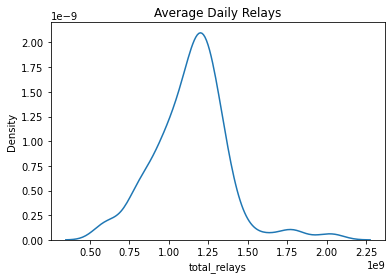

In [5]:
sns.kdeplot(df['total_relays'])
plt.title("Average Daily Relays")
plt.show()

## Application EDA

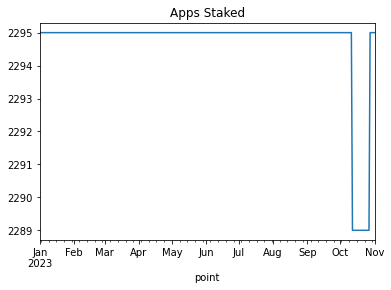

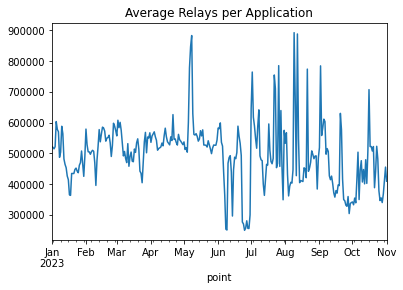

In [6]:
df['apps_staked'].plot(kind='line')
plt.title("Apps Staked")
plt.show()

(df['total_relays'] / df['apps_staked']).plot(kind='line')
plt.title("Average Relays per Application")
plt.show()

## Service EDA

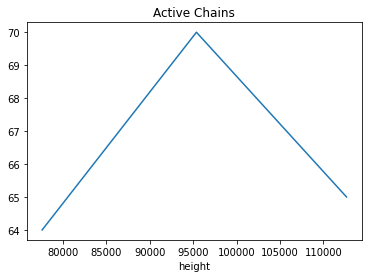

In [7]:
(~pd.isnull(chain_df)).sum().plot(kind='line')
plt.title("Active Chains")
plt.show()

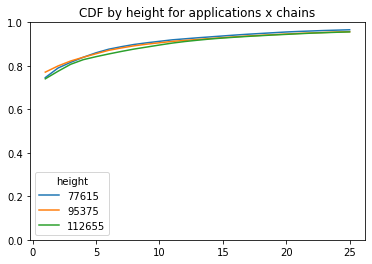

In [8]:
chain_cdfs.plot(kind='line')
plt.ylim([0, 1])
plt.title("CDF by height for applications x chains")
plt.show()

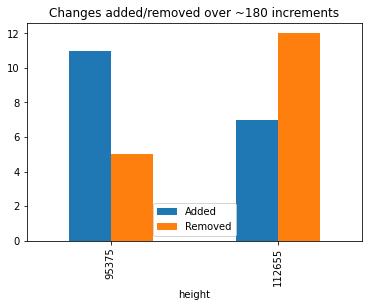

In [9]:
adds_removes.columns = ["Added", "Removed"]
adds_removes.plot(kind='bar')
plt.title("Changes added/removed over ~180 increments")
plt.show()

## Servicer EDA

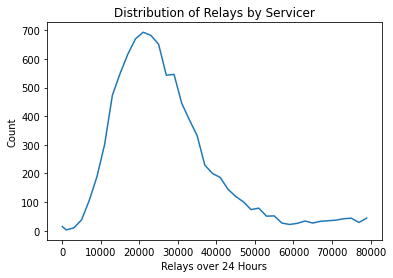

In [10]:
relay_hist["average"] = (relay_hist["start"]+relay_hist["end"])/2
relay_hist.set_index("average")['count'].plot(kind='line')
plt.title("Distribution of Relays by Servicer")
plt.xlabel("Relays over 24 Hours")
plt.ylabel("Count")
plt.show()

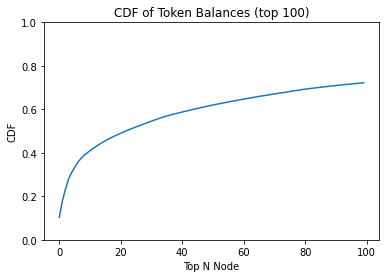

In [11]:
top_accounts['cdf'].plot(kind='line')
plt.ylim(0, 1)
plt.title("CDF of Token Balances (top 100)")
plt.xlabel("Top N Node")
plt.ylabel("CDF")
plt.show()

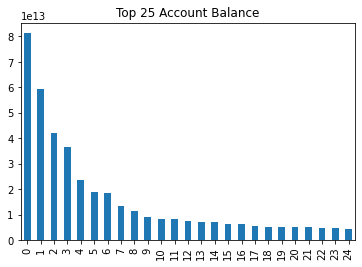

In [12]:
top_accounts.iloc[:25]['balance'].astype(int).plot(kind='bar')
plt.title("Top 25 Account Balance")
plt.show()

In [13]:
multiplier = 1 / top_accounts['cdf'].iloc[24]
mu = top_accounts.iloc[:25]['balance'].astype(float).mean()
std = top_accounts.iloc[:25]['balance'].astype(float).std()
mu = mu * multiplier
std = std * multiplier ** .5

print("Top 25 distribution of funds:")
print("mu:")
print(mu)
print("std:")
print(std)

Top 25 distribution of funds:
mu:
31498823311473.4
std:
26884303951795.508


## Average Block Size per Day

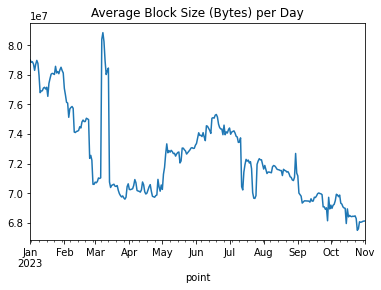

In [20]:
df['total_size_avg_by_block'].plot(kind='line')
plt.title("Average Block Size (Bytes) per Day")
plt.show()

In [21]:
print(df['total_size_avg_by_block'].mean())
print(df['total_size_avg_by_block'].std())

72401611.75349943
2968396.6445908416


## Etc

Below number is for average **over** the full window, by application.

In [14]:
query = gql("""
query {
  GetStakedAndRelaysByAppsAveragesBetweenDates(
    input: {
      start_date: "2023-01-01",
      end_date: "2023-11-01",
      date_format: "YYYY-MM-DD"
    }
  ) {
    avg_staked,
    avg_relays
  }
}
""")

try:   
    # Execute the query and get the results
    response = client.execute(query)

    # Convert the result to a pandas DataFrame
    print(response['GetStakedAndRelaysByAppsAveragesBetweenDates'])


    
except Exception as e:
    print(f"An error occurred: {e}")

{'avg_staked': 1775042409.9233115, 'avg_relays': 151303770.39565462}


## ETC - Abandoned Queries

In [13]:
query = gql("""
query {
  GetNodesTotalBalanceAndTokensByFilter(
    input: {
    filter: {operator: AND,
    properties: [],
    filters: []}
    }
  ) {
        total_tokens,
        total_balance
  }
}
""")

try:   
    # Execute the query and get the results
    response = client.execute(query)

    # Convert the result to a pandas DataFrame
    df = pd.DataFrame(response['ListSummaryBetweenDates']['points'])

    # Generate a timestamp and integrate it into the filename
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    df = df.set_index('point')
    df.index = pd.to_datetime(df.index)
    
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: {'message': '$and/$or/$nor must be a nonempty array', 'locations': [{'line': 2, 'column': 3}], 'path': ['GetNodesTotalBalanceAndTokensByFilter'], 'extensions': {'code': 'INTERNAL_SERVER_ERROR', 'exception': {'ok': 0, 'code': 2, 'codeName': 'BadValue', '$clusterTime': {'clusterTime': {'$timestamp': '7299198947053010946'}, 'signature': {'hash': '5xKsS7oba8mS5nRnG+GJ4OAV7dE=', 'keyId': {'low': 80, 'high': 1687969357, 'unsigned': False}}}, 'operationTime': {'$timestamp': '7299198947053010946'}}}}
